# Notes on Computing the Rollout Acquisition Function
## Considerations
- Using expected improvement as a control variate doesn't behave as anticipated. You can inspect the difference between acquisitions evaluated with or without this control variate by setting the named argument in, simulate_trajectory, variance_reduction to false or true, i.e.: `simulate_trajectory(..., variance_reduction=true)`. The logic for implementing the EI control variate is located at `src/rollout.jl`.

In [6]:
using Distributions
using LinearAlgebra
using Plots

All the necessary imports for our computations of interest

In [24]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

generate_initial_guesses (generic function with 1 method)

## Basic Setup

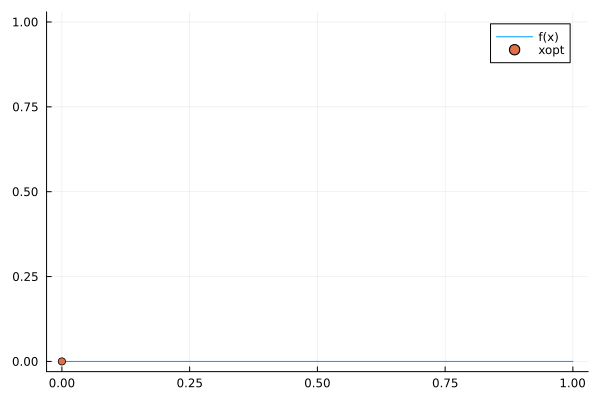

In [25]:
# Visualize 1D test function
# testfn = TestLinearCosine1D(1., 9.2)
testfn = TestConstant(lbs=[0.], ubs=[1.])
tplot(testfn)

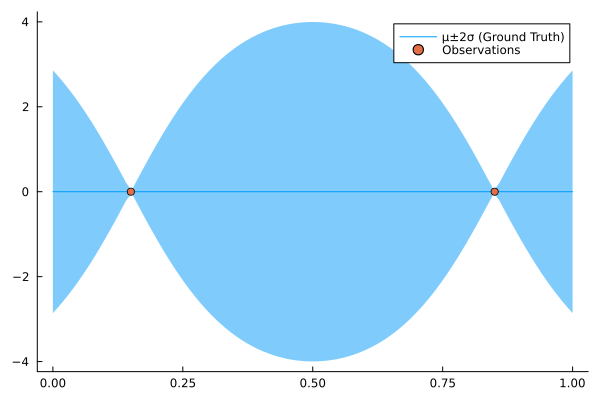

In [33]:
MC_SAMPLES = 1000
NUMBER_OF_STARTS = 8
HORIZON = 1
USE_LDS = false
INITIAL_SAMPLES = 8

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
# ψ = kernel_matern52(θ)
ψ = kernel_scale(kernel_matern52, [5., .25])

lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]

# Generate low discrepancy sequence and standard pseudo-random sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_guesses[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    USE_LDS ? lds_rns : rns,
    lbs,
    ubs,
)

# Initialize shared memory for solving base policy in parallel. These values
# are passed to the simulate_trajectory function. We solve the inner policy
# with `NUMBER_OF_STARTS` random starts.
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

# Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
Xinit = [.15;; .85;;]
yinit = testfn.f.(eachcol(Xinit))

# Fit surrogate with hyperparameters learned via MLE
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
# sur = optimize_hypers_optim(
#     fit_surrogate(ψ, Xinit, yinit; σn2=σn2),
#     kernel_matern52
# )
plot1D(sur, xmin=first(lbs), xmax=first(ubs))

## Dense Evaluation of Rollout Acquisition Function
(TODO) See if the variance in our estimator is decreasing.

In [34]:
domain = first(lbs):.01:first(ubs)
# Simulate trajectory returns the acqusition, gradient of acquisition and their standard errors
tpd = zeros(length(domain), 4)
tpdvr = zeros(length(domain), 4)
coeffs = []
correlations = []
vs = []


for (i, x0) in enumerate(domain)
    print("|")
    tp.x0[:] = [x0]

    outcome = simulate_trajectory(sur, tp, initial_guesses, variance_reduction=true,
        candidate_locations=candidate_locations, candidate_values=candidate_values, use_crn=true
    )
    tpd[i, :] .= [outcome[1], first(outcome[2]), outcome[3], first(outcome[4])]
    
    tp.x0[:] = [x0]
    outcome = simulate_trajectory(sur, tp, initial_guesses, variance_reduction=false,
        candidate_locations=candidate_locations, candidate_values=candidate_values, use_crn=true
    )
    tpdvr[i, :] .= [outcome[1], first(outcome[2]), outcome[3], first(outcome[4])]
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Visualize the acquisition

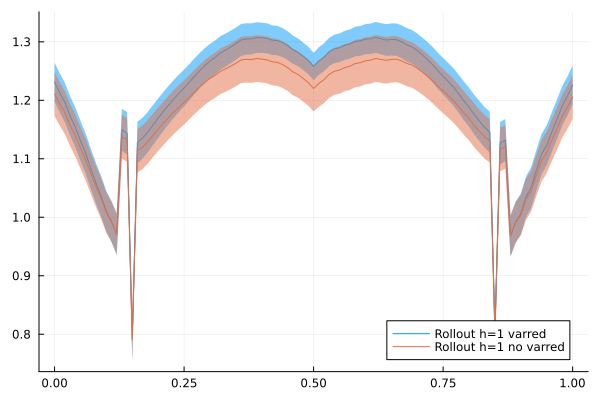

In [35]:
plot(
    domain,
    tpd[:, 1],
    ribbons=tpd[:, 3] / sqrt(tp.mc_iters),
    label="Rollout h=$HORIZON varred"
)
plot!(
    domain,
    tpdvr[:, 1],
    ribbons=tpdvr[:, 3] / sqrt(tp.mc_iters),
    label="Rollout h=$HORIZON no varred"
)
# plot!(
#     domain,
#     [sur([x]).EI for x in domain],
#     label="Expected Improvement"
# )
# scatter!(sur.X', zeros(length(sur.X')))

In [39]:
maximum(tpdvr[:, 3] ./ tpd[:, 3])

1.6861477620738428

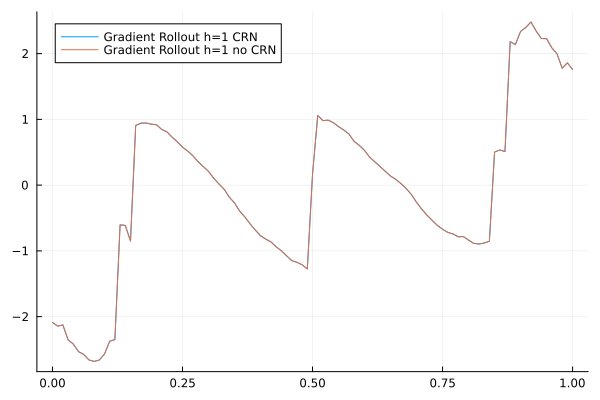

In [41]:
plot(
    domain,
    tpd[:, 2],
    # ribbons=trajectory_payloads[:, 4],
    label="Gradient Rollout h=$HORIZON CRN"
)
plot!(
    domain,
    tpdvr[:, 2],
    # ribbons=trajectory_payloads_no_crn[:, 4],
    label="Gradient Rollout h=$HORIZON no CRN"
)
# scatter!(sur.X', zeros(length(sur.X')))